In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-11-13 18:28:38.168264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 18:28:38.177264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 18:28:38.180182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


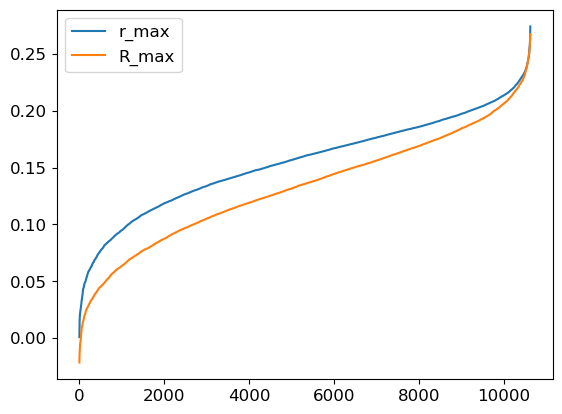

In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

# Define file directory and load data
dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

# Prepare X, Y, Z based on loaded data
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
Z = np.array(data['R_max']).reshape(-1, 1)  # Shape Z as (nrows, 1)

# Transpose X and Y to shape (nrows, ncols)
X, Y = X.T, Y.T

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # Shared scaler for Y and Z

# Fit-transform X
x = scaler_X.fit_transform(X)

# Mask and scale non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten() 

# Scale Z with the same scaler as Y
z = scaler_Y.transform(Z)

# Split the data for training and validation as required
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

y_tr2, y_ts2, z_tr, z_ts = train_test_split(y, z, test_size=0.2, random_state=42)
y_ts2, y_vl, z_ts, z_vl = train_test_split(y_ts2, z_ts, test_size=0.01, random_state=42)

min_y = np.array([np.min(row[row != 0]) for row in y])
plt.plot(np.sort(min_y, axis=0), label='r_max')
plt.plot(np.sort(z.flatten(), axis=0), label='R_max')
plt.legend()
plt.show()

In [10]:
# Load model from file
#model = tf.keras.models.load_model("../../models/model_nl.keras")

model1 = tf.keras.models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(x_ncols,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(y_ncols, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='mse')
model1.summary()

batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,332 (1.22 MB)

 Trainable params: 319,332 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
training1 = model1.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early, lr_schedule], verbose=1)

Epoch 1/1000


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0443 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0023 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0012 - val_loss: 9.5585e-04 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 8.7431e-04 - val_loss: 7.1425e-04 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 6.3760e-04 - val_loss: 5.6865e-04 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 5.3850e-04 - val_loss: 4.9469e-04 - learning_rate: 0.0010
Epoch 8/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 4.6826e-04 - val_loss: 4.1593e-04 - learning_rate: 0.0010
Epoch 9/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 3.8091e-04 - val_los

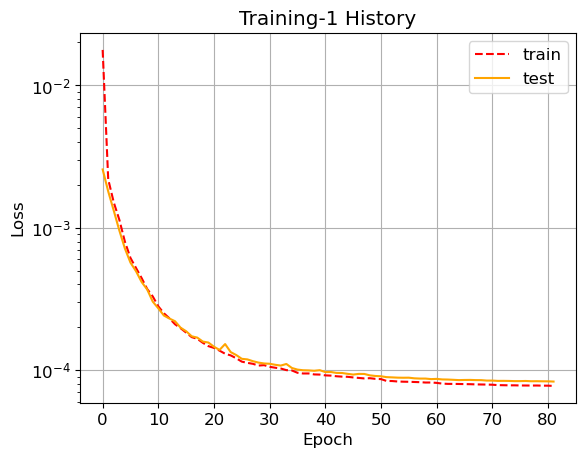

In [12]:
plt.semilogy(training1.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training1.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training-1 History")
plt.legend()
plt.show()

In [16]:
model2 = tf.keras.models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(y_ncols,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='mse')
model2.summary()

batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-5, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,081 (148.75 KB)

 Trainable params: 38,081 (148.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
training2 = model2.fit(x=y_tr2, y=z_tr, batch_size=batch_size, validation_data=(y_ts2, z_ts), \
                    epochs=num_epochs, callbacks=[early_stop, lr_schedule], verbose=1)

Epoch 1/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0343 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.0033 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0027 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0020 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.0011 - val_loss: 9.9309e-04 - learning_rate: 0.0010
Epoch 8/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 9.7372e-04 - val_loss: 9.5468e-04 - learning_rate: 0.0010
Epoch 9/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 9.1175e-04 - val_loss: 9.3967e-

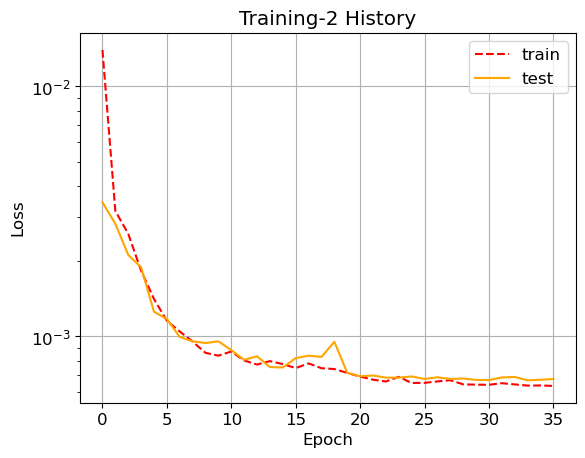

In [18]:
plt.semilogy(training2.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training2.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training-2 History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


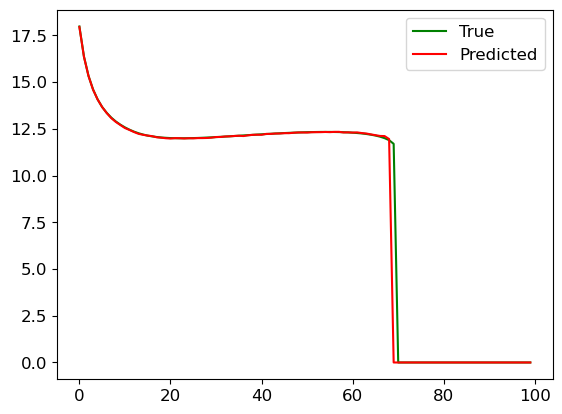

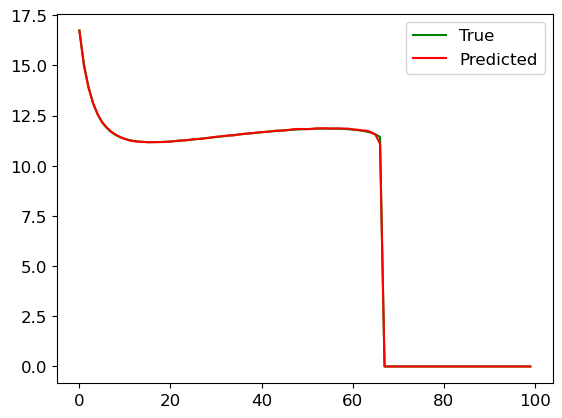

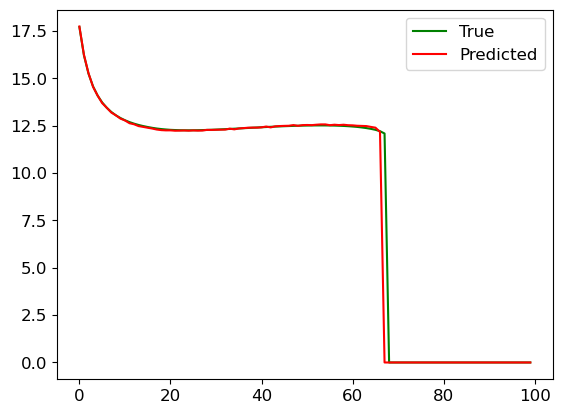

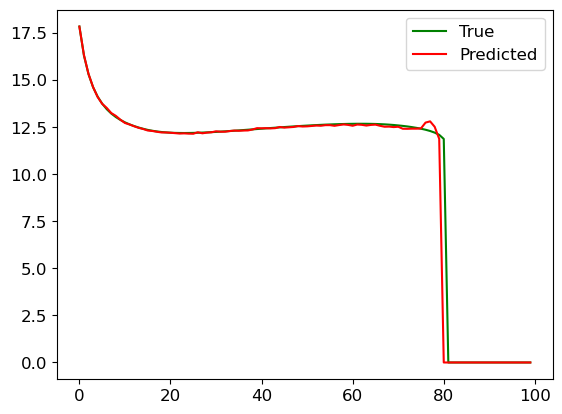

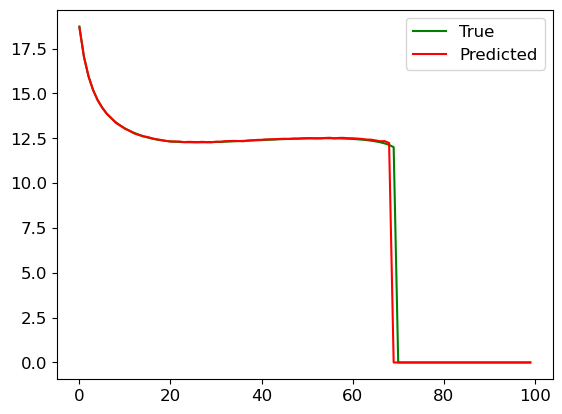

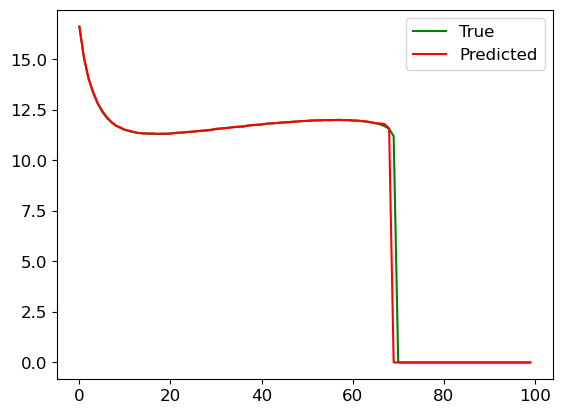

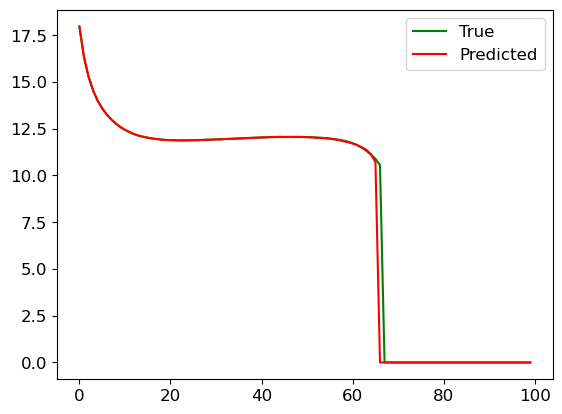

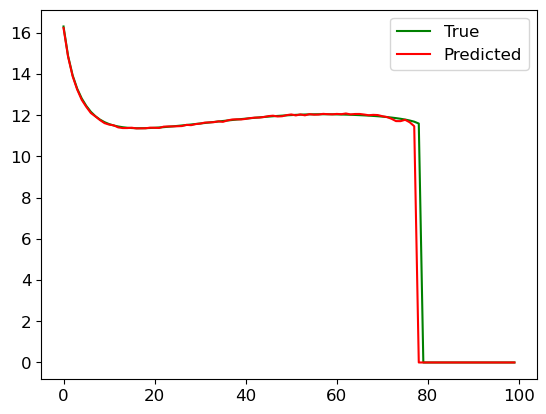

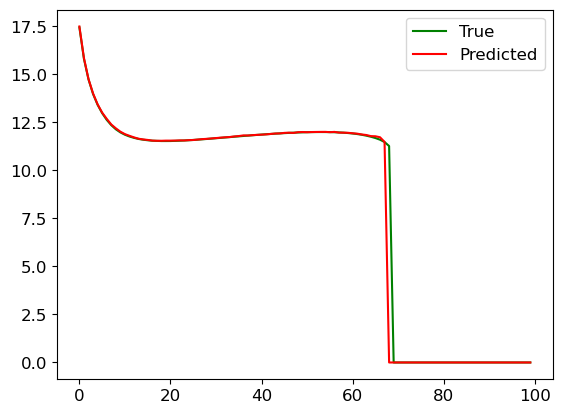

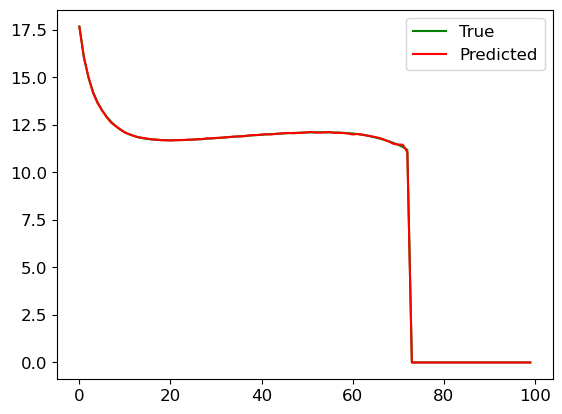

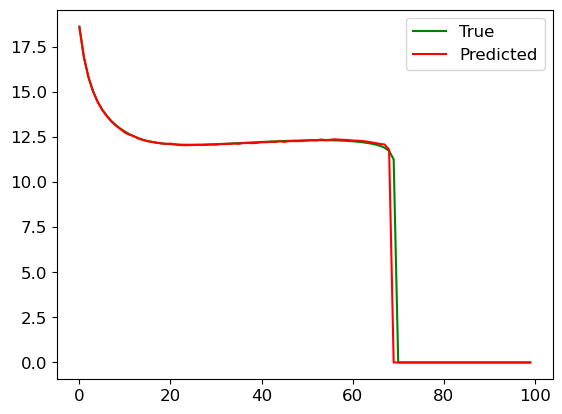

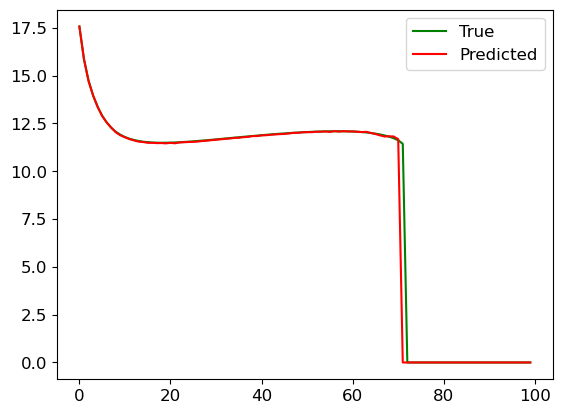

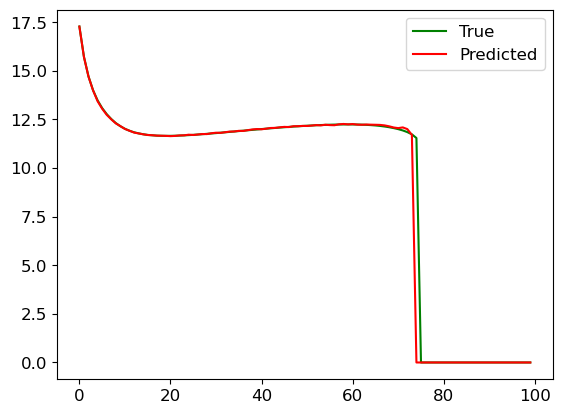

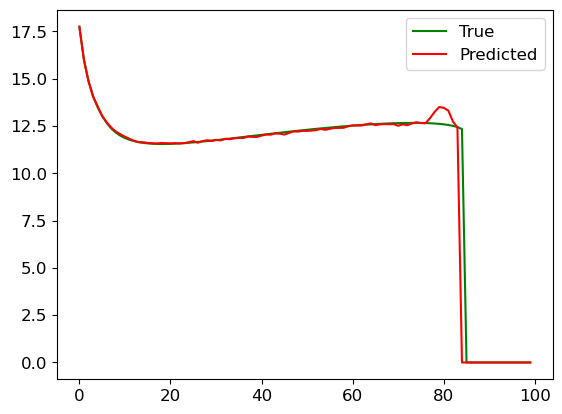

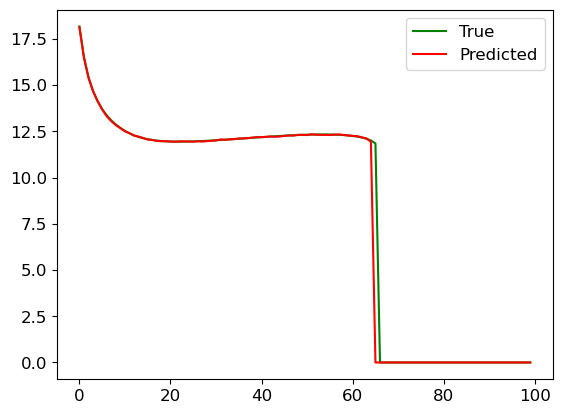

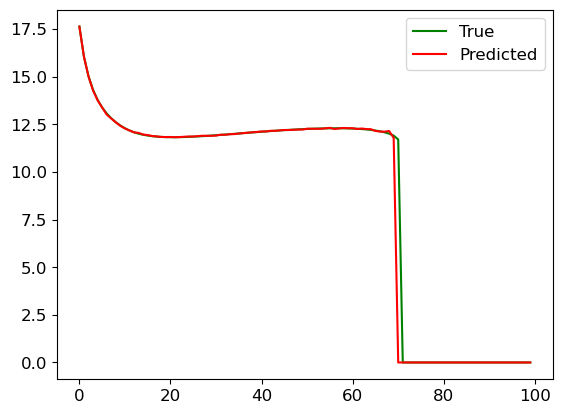

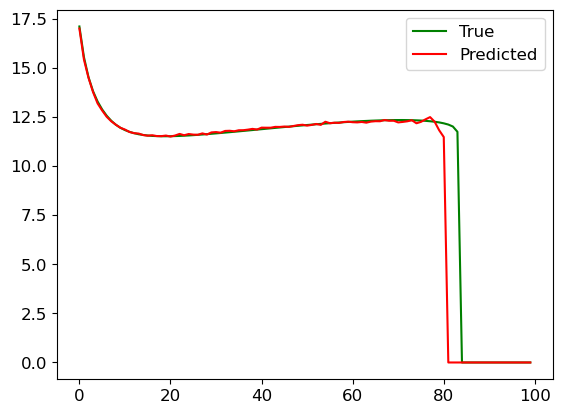

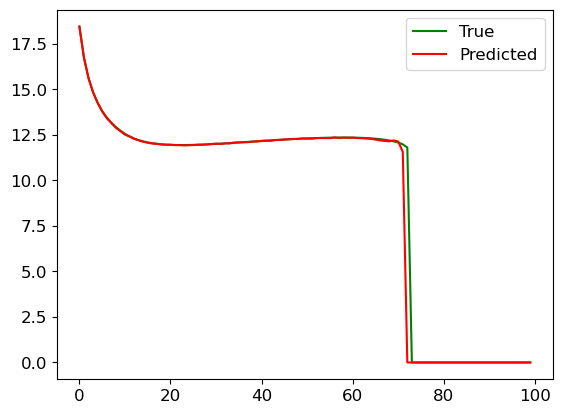

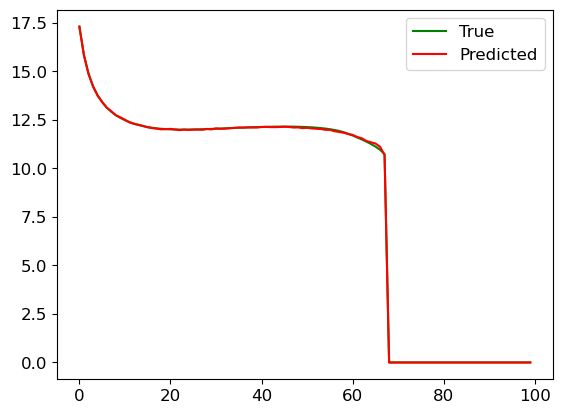

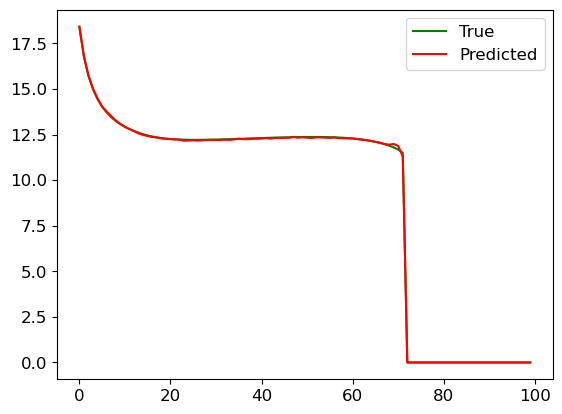

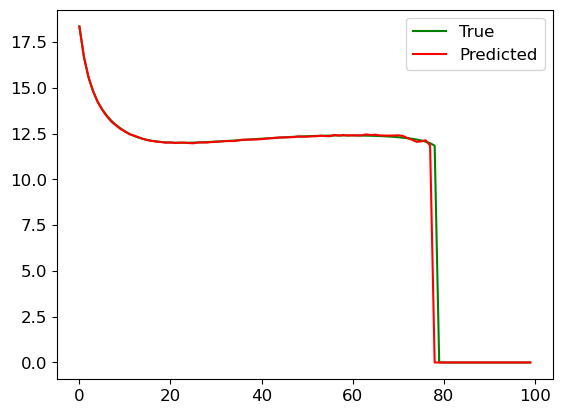

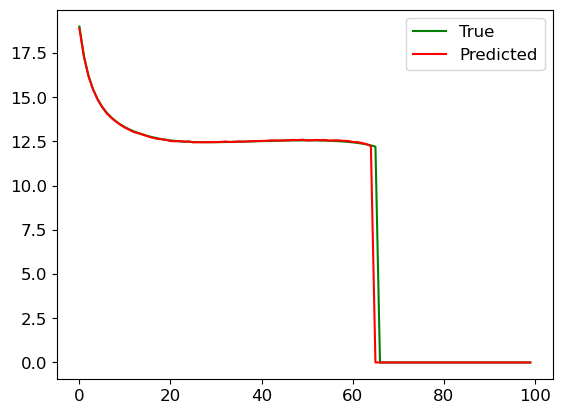

In [24]:
y_pr = model1.predict(x_vl)
z_pr = model2.predict(y_pr)

# Post-processing loop to zero values in y_pr based on z_pr, starting from the last element
for i in range(len(y_pr)):
    for j in range(len(y_pr[i]) - 1, -1, -1):  # Start from the last element in y_pr[i]
        v = y_pr[i][j]
        if v > z_pr[i]:  # Stop setting to zero once v > z_pr[i]
            break
        y_pr[i][j] = 0  # Set values to zero

nz_pr = y_pr != 0
nz_vl = y_vl != 0

Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

Y_pr[nz_pr] = scaler_Y.inverse_transform(y_pr[nz_pr].reshape(-1, 1)).flatten()
Y_vl[nz_vl] = scaler_Y.inverse_transform(y_vl[nz_vl].reshape(-1, 1)).flatten()

Y_pr1 = np.copy(Y_pr)

for i in range(y_pr.shape[0]):
    plt.plot(Y_vl[i], label='True', c='green')
    plt.plot(Y_pr[i], label='Predicted', c='red')
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


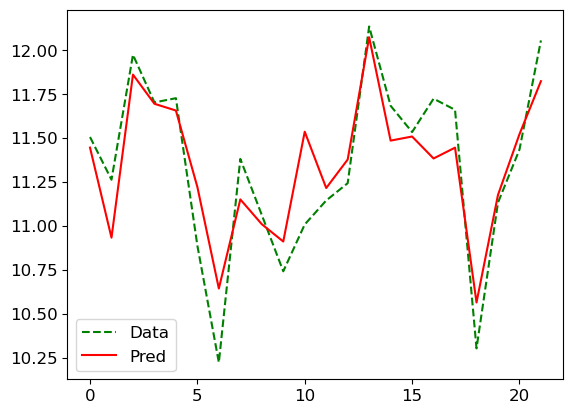

In [25]:
y_pr = model1.predict(x_vl)
z_pr = model2.predict(y_pr)
Z_pr = scaler_Y.inverse_transform(z_pr).flatten()
Z_vl = scaler_Y.inverse_transform(z_vl).flatten()
plt.plot(Z_vl, label='Data', c='g', ls='--')
plt.plot(Z_pr, label='Pred', c='r')
plt.legend()
plt.show()

In [26]:
# Step 1: Modify the last value in each X_vl[i] by multiplying it by 1.01
X_vl = scaler_X.inverse_transform(x_vl)  # Inverse transform x_vl to get X_vl

X_vl_modified = np.copy(X_vl)  # Make a copy to avoid altering the original validation set

for i in range(len(X_vl_modified)):
    X_vl_modified[i, -1] *= 1.1  # Multiply the last element by 1.01

# Step 2: Transform the modified X_vl back to x_vl
x_vl_modified = scaler_X.transform(X_vl_modified)

y_pr = model1.predict(x_vl_modified)
z_pr = model2.predict(y_vl)

for i in range(len(y_pr)):
    for j in range(len(y_pr[i]) - 1, -1, -1):
        v = y_pr[i][j]
        if v > z_pr[i]:
            break
        y_pr[i][j] = 0

nz_pr = y_pr != 0
Y_pr = np.copy(y_pr)
Y_pr[nz_pr] = scaler_Y.inverse_transform(y_pr[nz_pr].reshape(-1, 1)).flatten()
Y_pr2 = np.copy(Y_pr)

for i in range(y_pr.shape[0]):
    i_max1 = np.max(np.nonzero(Y_pr1[i]))
    i_max2 = np.max(np.nonzero(Y_pr2[i]))
    print('imax1 =', i_max1, 'imax2 =',i_max2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
imax1 = 68 imax2 = 68
imax1 = 66 imax2 = 66
imax1 = 66 imax2 = 66
imax1 = 79 imax2 = 79
imax1 = 68 imax2 = 69
imax1 = 68 imax2 = 68
imax1 = 65 imax2 = 65
imax1 = 77 imax2 = 77
imax1 = 67 imax2 = 67
imax1 = 72 imax2 = 72
imax1 = 68 imax2 = 69
imax1 = 70 imax2 = 70
imax1 = 73 imax2 = 74
imax1 = 83 imax2 = 83
imax1 = 64 imax2 = 64
imax1 = 69 imax2 = 69
imax1 = 80 imax2 = 81
imax1 = 71 imax2 = 71
imax1 = 67 imax2 = 67
imax1 = 71 imax2 = 71
imax1 = 77 imax2 = 77
imax1 = 64 imax2 = 64
